In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:57<00:00, 42.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [2]:
import numpy as np # linear algebra
import pandas as pd

In [3]:
!mv /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2 /content/chest-xray


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [5]:
main_path = "/content/chest-xray/chest_xray"

In [6]:
from sklearn.metrics import classification_report
import seaborn as sns
import glob
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

pneumonia_train_images = glob.glob(train_path+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_path+"/NORMAL/*.jpeg")

pneumonia_val_images = glob.glob(val_path+"/PNEUMONIA/*.jpeg")
normal_val_images = glob.glob(val_path+"/NORMAL/*.jpeg")

pneumonia_test_images = glob.glob(test_path+"/PNEUMONIA/*.jpeg")
normal_test_images = glob.glob(test_path+"/NORMAL/*.jpeg")

In [7]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train_images) , [1] *  len(pneumonia_train_images)]),columns=["class"])

<Axes: xlabel='class', ylabel='count'>

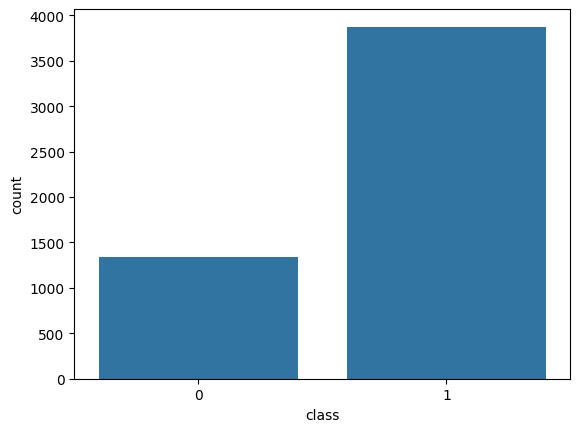

In [8]:
import seaborn as sns

sns.countplot(x='class', data=data)  # Corrected


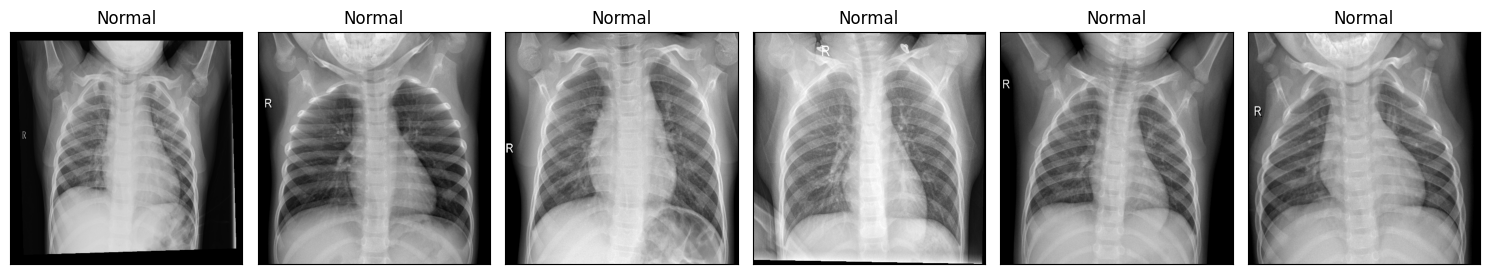

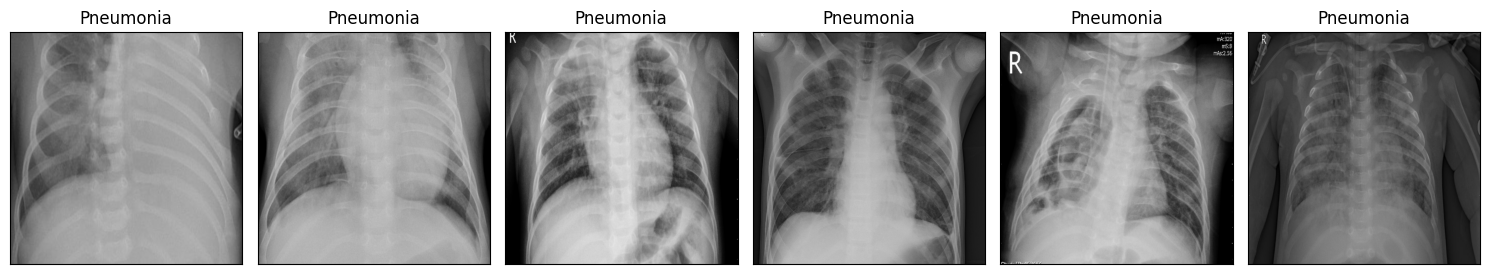

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    ax.imshow(img)
    ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

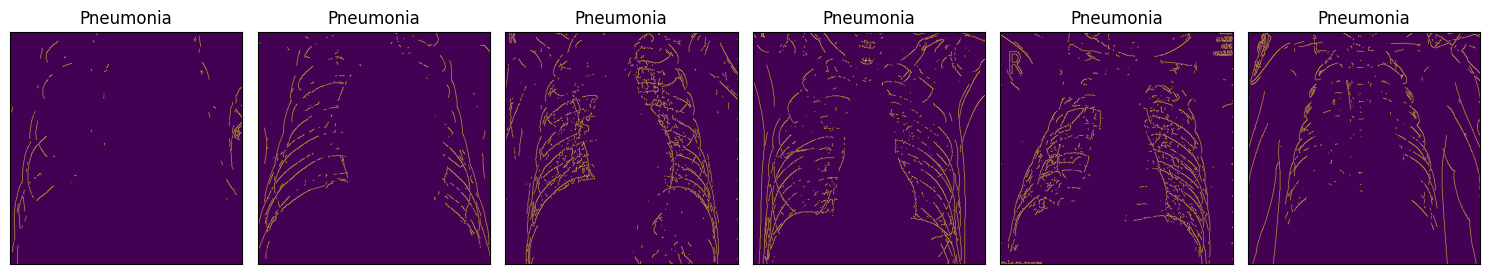

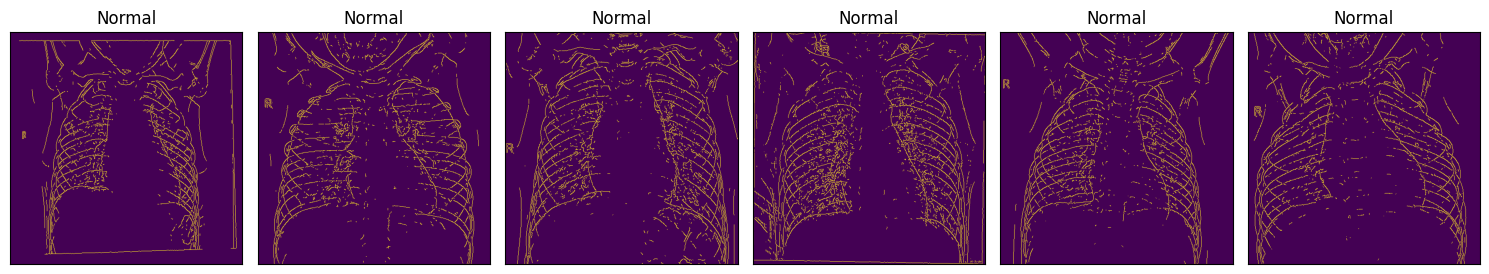

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (512,512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.Canny(img, 80, 100)
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()
plt.show()

In [11]:
val_Pneumonia = len(os.listdir(val_path+'/PNEUMONIA'))
val_Normal =len(os.listdir(val_path+'/NORMAL'))
print(f'len(val_Normal) = {val_Normal},len(val_Pneumonia)={val_Pneumonia}')

len(val_Normal) = 8,len(val_Pneumonia)=8


In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,

        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_path, batch_size=32,  target_size = (220, 220), class_mode="categorical",
    color_mode='rgb',
    shuffle=True,
    subset='training')
validation_generator = val_datagen.flow_from_directory(test_path, batch_size=32,  target_size=(220, 220), class_mode="categorical",
    color_mode='rgb',
    shuffle=True)
test_generator = test_datagen.flow_from_directory(val_path, batch_size=32,  target_size=(220, 220), class_mode="categorical",
    color_mode='rgb',
    shuffle=False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
input_shape=(220,220,3)

In [14]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,827,330 (90.89 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [15]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_generator,
                    epochs=15,
                    steps_per_epoch = 5216// 32,
                    validation_data = validation_generator,
                    validation_steps = 624 // 32)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 711ms/step - accuracy: 0.8815 - loss: 0.3004 - val_accuracy: 0.8701 - val_loss: 0.3287
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 677ms/step - accuracy: 0.9385 - loss: 0.1505 - val_accuracy: 0.9128 - val_loss: 0.2456
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 877ms/step - accuracy: 0.9463 - loss: 0.1353 - val_accuracy: 0.9161 - val_loss: 0.2478
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 739ms/step - accuracy: 0.9591 - loss: 0.1172 - val_accuracy: 0.9062 - val_loss: 0.2605
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 870ms/step - accuracy: 0.9607 - loss: 0.1100 - val_accuracy: 0.9211 - val_loss: 0.2211
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 172s 689ms/step - accuracy: 0.9591 - loss: 0.1016 - val_accuracy: 0.8898 - val_loss: 0.2620
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 690ms/step - accuracy: 0.9673 - loss: 0.0983 - val_accuracy: 0.8980 - val_loss: 0.2700
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 687ms/step - accuracy: 0.9569 -

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
val_loss, val_accuracy = model.evaluate(validation_generator)

y_pred = model.predict(validation_generator)

# Threshold the predictions to obtain binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

dummy_val_labels = validation_generator.classes  # Assuming your validation generator has class indices

# Reshape true labels if necessary
# Flatten true labels and predicted labels to compute metrics
y_true = dummy_val_labels.reshape(-1)
y_pred_binary = y_pred_binary.reshape(-1)

# Compute precision, recall, and F1-score
#precision = precision_score(y_true, y_pred_binary)
#recall = recall_score(y_true, y_pred_binary)
#f1 = f1_score(y_true, y_pred_binary)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
#print("Precision:", precision)
#print("Recall:", recall)
#print("F1-score:", f1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 563ms/step - accuracy: 0.9164 - loss: 0.2442
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step
Validation Loss: 0.2252465933561325
Validation Accuracy: 0.9278846383094788


In [17]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

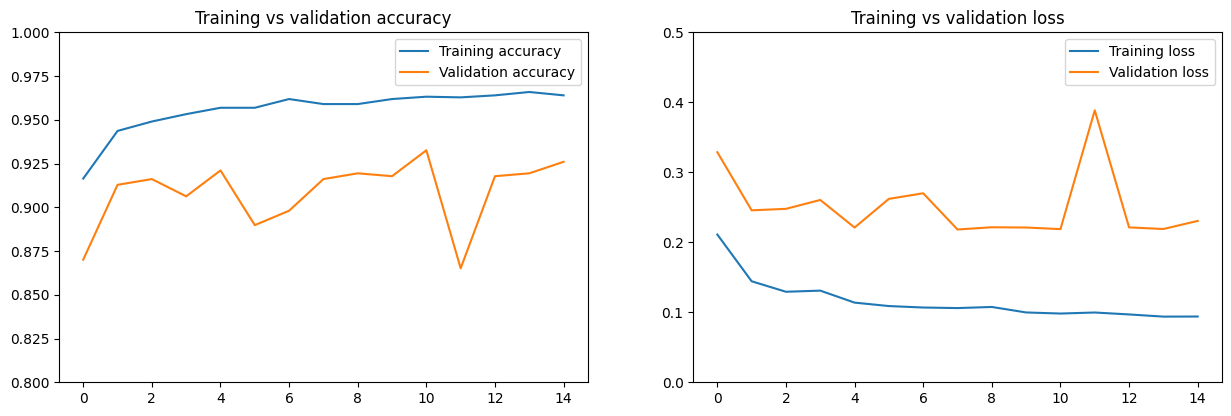

In [18]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.ylim(0.8, 1)
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.ylim(0, 0.5)
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [25]:
model.save("resent_50_model.keras")

In [21]:
from tensorflow.keras.applications import MobileNetV2
base_model_3 = MobileNetV2(weights='imagenet',input_shape=input_shape, include_top=False)
for layer in base_model_3.layers:
    layer.trainable = False

model_2 = Sequential()
model_2.add(base_model_3)
model_2.add(GlobalAveragePooling2D())
model_2.add(Dense(128, activation = 'relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(2, activation='sigmoid'))
model_2.summary()

<ipython-input-21-16495524a501>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_3 = MobileNetV2(weights='imagenet',input_shape=input_shape, include_top=False)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
model_2.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history_2 = model_2.fit(train_generator,
                    epochs=20,
                    steps_per_epoch = 5216// 32,
                    validation_data = validation_generator,
                    validation_steps = 624 // 32)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 664ms/step - accuracy: 0.8917 - loss: 0.2879 - val_accuracy: 0.9013 - val_loss: 0.2521
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 585ms/step - accuracy: 0.9461 - loss: 0.1419 - val_accuracy: 0.8734 - val_loss: 0.2941
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 593ms/step - accuracy: 0.9500 - loss: 0.1356 - val_accuracy: 0.8701 - val_loss: 0.3196
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 624ms/step - accuracy: 0.9561 - loss: 0.1107 - val_accuracy: 0.9079 - val_loss: 0.2461
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 597ms/step - accuracy: 0.9576 - loss: 0.1133 - val_accuracy: 0.8849 - val_loss: 0.2867
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 660ms/step - accuracy: 0.9518 - loss: 0.1218 - val_accuracy: 0.8964 - val_loss: 0.2804
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 879ms/step - accuracy: 0.9551 - loss: 0.1080 - val_accuracy: 0.8865 - val_loss: 0.2734
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 640ms/step - accuracy: 0.9527 - l

In [26]:
model_2.save("mobile_net_model.keras")

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
val_loss_2, val_accuracy_2 = model_2.evaluate(validation_generator)

y_pred_2 = model_2.predict(validation_generator)

# Threshold the predictions to obtain binary values (0 or 1)
y_pred_binary_2 = (y_pred_2 > 0.5).astype(int)

# Since you have a binary classification problem, you might not need explicit labels for evaluation
# However, if you have them, you can use them for computing metrics
# Here, I'm assuming you don't have explicit validation labels and using predicted labels for demonstration purposes
# You can replace this with actual labels if you have them

# Generate dummy labels for demonstration purposes
# These labels could be replaced with your actual validation labels if available
dummy_val_labels_2 = validation_generator.classes  # Assuming your validation generator has class indices

# Reshape true labels if necessary
# Flatten true labels and predicted labels to compute metrics
y_true_2 = dummy_val_labels_2.reshape(-1)
y_pred_binary_2 = y_pred_binary_2.reshape(-1)

# Compute precision, recall, and F1-score
#precision_v19 = precision_score(y_true_2, y_pred_binary_2)
#recall_v19 = recall_score(y_true_2, y_pred_binary_2)
#f1_v19 = f1_score(y_true_2, y_pred_binary_2)
print("Validation Loss:", val_loss_2)
print("Validation Accuracy:", val_accuracy_2)
#print("Precision:", precision_v19)
#print("Recall:", recall_v19)
#print("F1-score:", f1_v19)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.9022 - loss: 0.2977
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step
Validation Loss: 0.3113362193107605
Validation Accuracy: 0.8942307829856873


In [28]:
accuracy_MobileNet = history_2.history['accuracy']
val_accuracy_MobileNet  = history_2.history['val_accuracy']

loss_MobileNet = history_2.history['loss']
val_loss_MobileNet = history_2.history['val_loss']

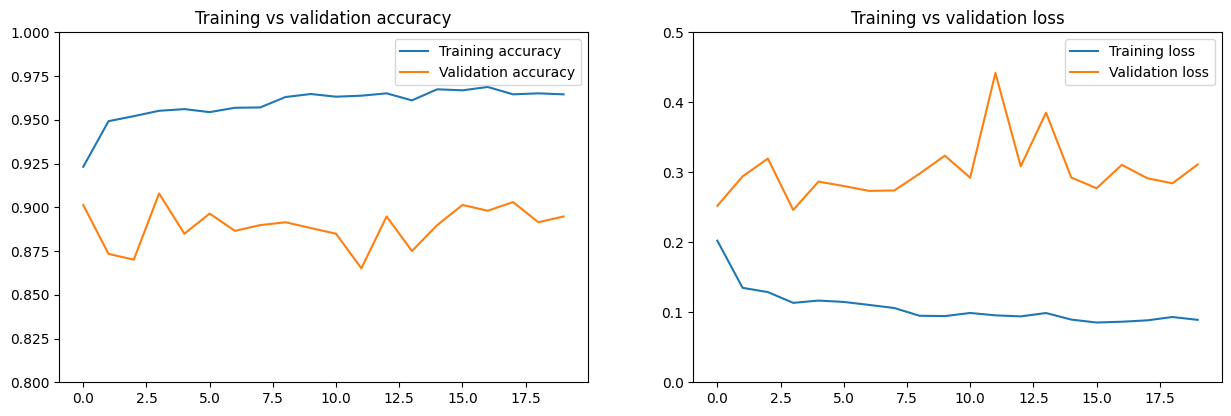

In [29]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy_MobileNet, label = "Training accuracy")
plt.plot(val_accuracy_MobileNet, label="Validation accuracy")
plt.ylim(0.8, 1)
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss_MobileNet, label = "Training loss")
plt.plot(val_loss_MobileNet, label="Validation loss")
plt.ylim(0, 0.5)
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [36]:
!pip install streamlit pyngrok

In [45]:
!pkill -9 streamlit
!pkill -9 ngrok

In [48]:
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os
from pyngrok import ngrok
import subprocess
import time
import socket

# Kill any existing Streamlit or ngrok processes to free up ports
!pkill -9 streamlit
!pkill -9 ngrok

# Load and compile the trained models
resnet_model = tf.keras.models.load_model("/content/resent_50_model.h5")
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

mobilenet_model = tf.keras.models.load_model("/content/mobile_net_model.h5")
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Save the Streamlit app to a file
code = """
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and compile the trained models
resnet_model = tf.keras.models.load_model("/content/resent_50_model.h5")
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

mobilenet_model = tf.keras.models.load_model("/content/mobile_net_model.h5")
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Streamlit Web Interface
st.title("Pneumonia Detection using Deep Learning")
st.write("Upload a Chest X-ray image to check for Pneumonia.")

uploaded_file = st.file_uploader("Choose an X-ray image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Choose model for prediction
    model_choice = st.radio("Select Model", ("ResNet50", "MobileNetV2"))

    # Preprocess the image - both models expect 220x220
    if model_choice == "ResNet50":
        model = resnet_model
    else:
        model = mobilenet_model

    img = image.load_img(uploaded_file, target_size=(220, 220))  # Unified size for both models
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)
    label = "PNEUMONIA" if np.argmax(prediction) == 1 else "NORMAL"

    # Display the image and result
    st.image(uploaded_file, caption=f'Predicted: {label}', use_column_width=True)
    st.write(f"The model predicts: **{label}**")
"""

# Write the Streamlit app to a file
with open("app.py", "w") as f:
    f.write(code)

# Install required packages"""  """
#!pip install streamlit pyngrok -q

# Set your ngrok authtoken (replace with your actual token)
ngrok.set_auth_token("")  # Replace with your token

# Start the Streamlit app in the background
process = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"],
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Wait for Streamlit to start
time.sleep(10)

# Check if the port is active (Streamlit is running)
def is_port_in_use(port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex(('localhost', port)) == 0

if is_port_in_use(8501):
    # Create a tunnel with ngrok
    public_url = ngrok.connect(8501)
    print(f"Streamlit app is live at: {public_url}")
else:
    print("Streamlit failed to start. Here’s the error output:")
    stderr = process.stderr.read().decode()
    print(stderr)
    process.kill()  # Clean up the failed process

Streamlit app is live at: NgrokTunnel: "https://8f13-34-147-114-240.ngrok-free.app" -> "http://localhost:8501"
